In [437]:
import torchvision.models as models                   

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [438]:
from numpy import asarray, percentile, tile
import torch.nn as nn
from scipy.ndimage import gaussian_filter
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )
def image_converter(im):
    im_copy = im.cpu()
    
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    return im_copy

def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [439]:
def act_max(model, 
    input, 
    layer_activation, 
    layer_name, 
    unit, 
    steps=5, 
    alpha=torch.tensor(0.005),
    theta_decay=0.1,
    theta_every=4,
    theta_width=0.1,
    ):

    best_activation = -float('inf')
    best_img = input
    for k in range(steps):
        input.requires_grad_(True)
        input.retain_grad() 
        # network.zero_grad()
        
        # Propogate image
        model(input)
        layer_out = layer_activation[layer_name]

        # compute gradients
        layer_out[0][unit].backward(retain_graph=True)
        img_grad = input.grad

        # Gradient Step
        input = torch.add(input, torch.mul(img_grad, alpha))

        #L2_Decay
        #input = torch.mul(input, (1.0 - theta_decay))


        #Gaussian Blurr
        # if k % theta_every is 0:
        #     temp = input.squeeze(0)
        #     temp = temp.detach().numpy()
        #     for channel in range(3):
        #         cimg = gaussian_filter(temp[channel], theta_width)
        #         temp[channel] = cimg
        #     temp = torch.from_numpy(temp)
        #     input = temp.unsqueeze(0)

        # print('step: ', k, 'activation: ', layer_out[0][unit])
        if k % 10 == 0:
            final_image = image_converter(input.squeeze(0))
            plt.imshow(final_image)
            plt.show()
            print('step: ', k, 'activation: ', layer_out[0][unit])

        # Keep highest activation
        if layer_out[0][unit] - (0.05 * torch.norm(input)) > best_activation:
            best_activation = layer_out[0][unit]
            best_img = input
    return (best_activation, best_img)

In [440]:
def load_image(img_path, device=False):
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = img.convert('RGB')
    img = asarray(img).transpose(-1, 0, 1)
    img = img/255
    img = torch.from_numpy(img) 
    img = normalize(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    if device:
        img = img.type(torch.cuda.FloatTensor)
    else:
        img = img.type(torch.FloatTensor)
    return img


In [441]:
resnet50 = models.resnet50(pretrained = True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\neilh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [442]:
# uris = [
#     'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
# ]
# uri = 'https://salient-imagenet.cs.umd.edu/feature_visualization/class_130/feature_484/images/0.jpg'
# input = utils.prepare_input_from_uri(uri).to(device)
input = load_image('flamingo_image.jpg')
input.requires_grad_(True)

tensor([[[[-2.0665, -2.0665, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0323, -2.0323, -2.0494],
          ...,
          [ 1.6153,  1.9407,  2.1462,  ...,  2.1462,  2.2147,  2.2489],
          [ 1.1015,  1.8550,  2.1462,  ...,  2.1290,  2.1804,  2.2489],
          [ 0.4851,  1.7523,  2.2147,  ...,  2.1290,  2.1633,  2.2489]],

         [[-1.9832, -1.9832, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9482, -1.9482, -1.9657],
          ...,
          [-0.3025, -0.1275, -0.1099,  ...,  2.1310,  2.0784,  2.0084],
          [-0.5476, -0.1099, -0.1625,  ...,  2.1485,  2.0784,  2.0259],
          [-1.0028, -0.1275, -0.1450,  ...,  2.1660,  2.0609,  1.9734]],

         [[-1.7870, -1.7870, -1.7696,  ..., -1.7347, -1.7347, -1.7347],
          [-1.7696, -1.7696, -

In [443]:
result = resnet50(input)
value = result.detach().numpy()
k = max(value[0])


In [444]:
activation_dictionary = {}
layer_name = 'classifier_final'

list(resnet50.children())[-1].register_forward_hook(layer_hook(activation_dictionary, layer_name))

In [445]:
steps = 100    
unit = list(value[0]).index(k)   
print(unit)                
alpha = torch.tensor(1) 
print(input)
input = torch.add(input, torch.norm(input, float('inf')), alpha = (-1)*0.1)
print(input)                       

130
tensor([[[[-2.0665, -2.0665, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0323, -2.0323, -2.0494],
          ...,
          [ 1.6153,  1.9407,  2.1462,  ...,  2.1462,  2.2147,  2.2489],
          [ 1.1015,  1.8550,  2.1462,  ...,  2.1290,  2.1804,  2.2489],
          [ 0.4851,  1.7523,  2.2147,  ...,  2.1290,  2.1633,  2.2489]],

         [[-1.9832, -1.9832, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9482, -1.9482, -1.9657],
          ...,
          [-0.3025, -0.1275, -0.1099,  ...,  2.1310,  2.0784,  2.0084],
          [-0.5476, -0.1099, -0.1625,  ...,  2.1485,  2.0784,  2.0259],
          [-1.0028, -0.1275, -0.1450,  ...,  2.1660,  2.0609,  1.9734]],

         [[-1.7870, -1.7870, -1.7696,  ..., -1.7347, -1.7347, -1.7347],
          [-1.7696, -1.769

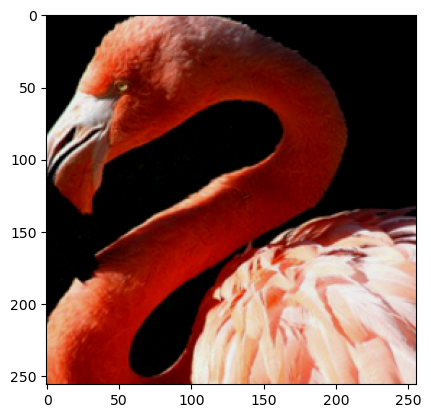

step:  0 activation:  tensor(24.8093, grad_fn=<SelectBackward0>)


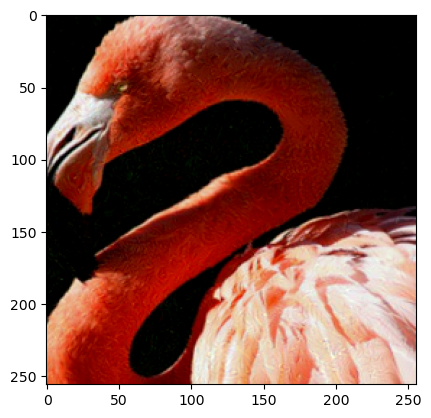

step:  10 activation:  tensor(73.4284, grad_fn=<SelectBackward0>)


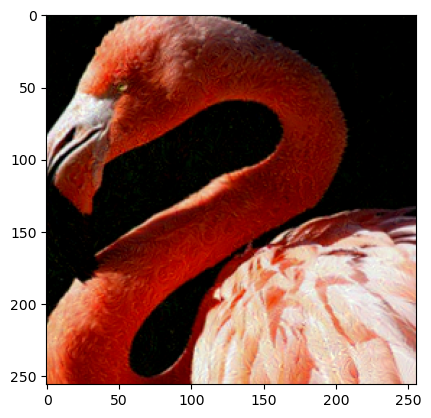

step:  20 activation:  tensor(104.5933, grad_fn=<SelectBackward0>)


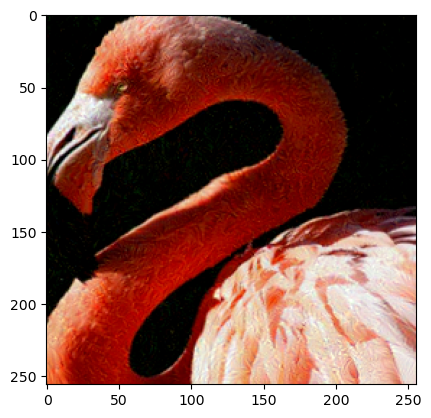

step:  30 activation:  tensor(134.4456, grad_fn=<SelectBackward0>)


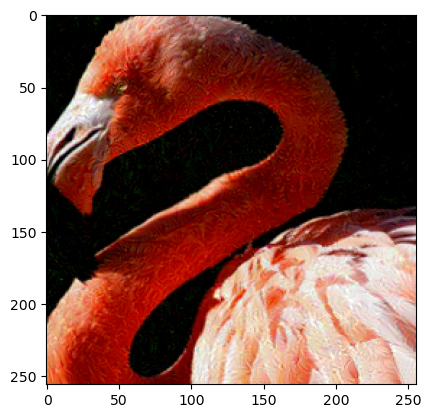

step:  40 activation:  tensor(160.6105, grad_fn=<SelectBackward0>)


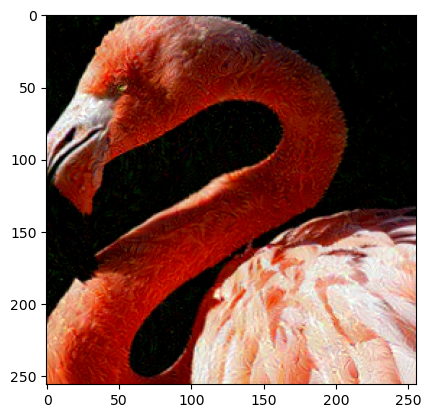

step:  50 activation:  tensor(174.1614, grad_fn=<SelectBackward0>)


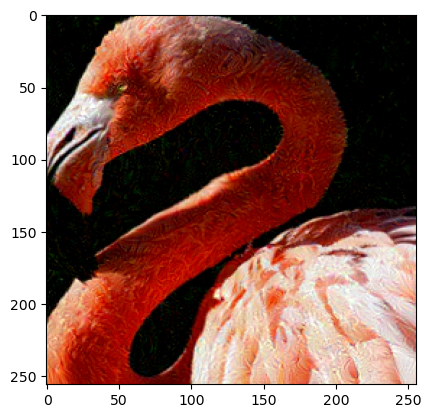

step:  60 activation:  tensor(182.2359, grad_fn=<SelectBackward0>)


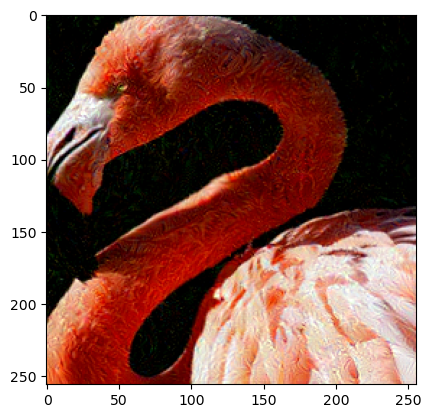

step:  70 activation:  tensor(209.6944, grad_fn=<SelectBackward0>)


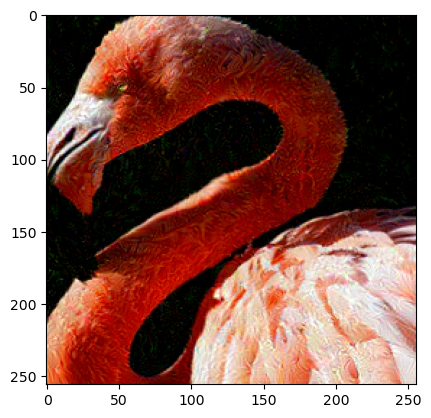

step:  80 activation:  tensor(216.9577, grad_fn=<SelectBackward0>)


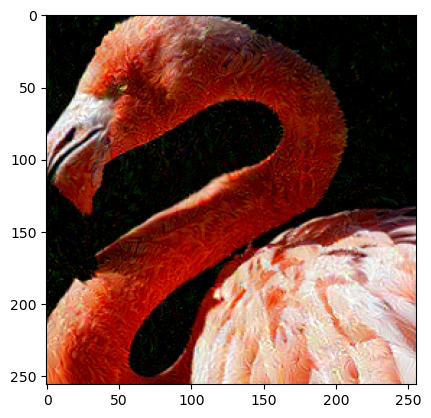

step:  90 activation:  tensor(232.6926, grad_fn=<SelectBackward0>)


In [446]:
acivation, output = act_max(model=resnet50,
                input=input,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                )

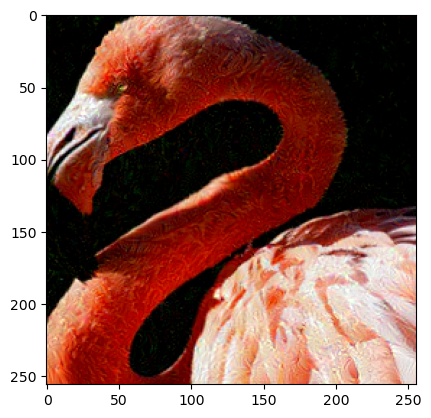

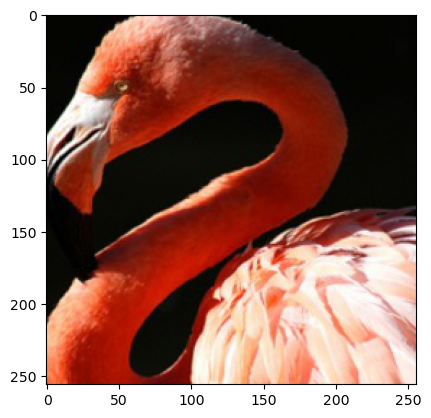

180.51933


In [452]:
result = resnet50(output)
value = result.detach().numpy()
k = max(value[0])
index = list(value[0]).index(k)
# print(k)
# print(acivation)
# print(index)
# print(unit)
final_image = image_converter(output.squeeze(0))
plt.imshow(final_image)
plt.show()
ori = load_image('flamingo_image.jpg')
ori = image_converter(ori.squeeze(0))
plt.imshow(ori)
plt.show()
assert(unit == index)
